In [1]:
import pandas as pd
from yome import Session
from yome.models import *
from yome.util import to_df, report, mpl_setup
from yome.constants import colors
import re
from sqlalchemy import or_, and_
from sqlalchemy.orm import aliased
import seaborn as sns
from Bio import SeqIO
import numpy as np
import gzip
import scipy.stats

In [2]:
%mpl_setup

Populating the interactive namespace from numpy and matplotlib


In [3]:
session = Session()

In [4]:
sns.set_style('ticks')

In [5]:
# get y-ome list
yome = to_df(
    session.query(
        Gene.locus_id,
        KnowledgebaseGene.annotation_quality
    )
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
    .filter(Knowledgebase.name == 'y-ome')
)

In [6]:
def _get_qual(feat, name, get_first=False):
    """Get a non-null attribute from the feature."""
    try:
        qual = feat.qualifiers[name]
    except KeyError:
        if get_first:
            return None
        else:
            return []

    def nonempty_str(s):
        s = s.strip()
        return None if s == '' else s

    if get_first:
        return nonempty_str(qual[0])
    else:
        return [y for y in (nonempty_str(x) for x in qual)
                if y is not None]

In [7]:
# Load genbank file
with gzip.open('../sources/refseq/NC_000913.3.gb.gz', 'rt') as f:
    gb_file = SeqIO.read(f, 'gb')
locs = {}
for feature in gb_file.features:
    # only read in CDSs
    if feature.type != 'CDS':
        continue

    locus_tag = _get_qual(feature, 'locus_tag', True)
    locs[locus_tag] = int(feature.location.start)

In [8]:
locs_df = pd.DataFrame({'locus_id': k, 'start': v} for k, v in locs.items())

In [9]:
starts = yome.merge(locs_df)

In [10]:
# based on https://stackoverflow.com/questions/28839246/scipy-gaussian-kde-and-circular-data

def vonmises_pdf(x, mu, kappa):
    return np.exp(kappa * np.cos(x - mu)) / (2. * np.pi * scipy.special.i0(kappa))

def vonmises_fft_kde(data, kappa, n_bins):
    bins = np.linspace(-np.pi, np.pi, n_bins + 1, endpoint=True)
    hist_n, bin_edges = np.histogram(data, bins=bins)
    bin_centers = np.mean([bin_edges[1:], bin_edges[:-1]], axis=0)
    kernel = vonmises_pdf(
        x=bin_centers,
        mu=0,
        kappa=kappa
    )
    kde = np.fft.fftshift(np.fft.irfft(np.fft.rfft(kernel) * np.fft.rfft(hist_n)))
    kde /= np.trapz(kde, x=bin_centers)
    return bin_centers, kde

In [11]:
# Import RNA -seq
log_tpm = pd.read_csv('../data/precise/tpm-log.tsv', sep='\t', index_col=0)

In [12]:
log_tpm.head()

,base__wt_glc__1,base__wt_glc__2,fur__wt_dpd__1,fur__wt_dpd__2,fur__wt_fe__1,fur__wt_fe__2,fur__delfur_dpd__1,fur__delfur_dpd__2,fur__delfur_fe2__1,fur__delfur_fe2__2,...,ssw__xyl_ale1__1,ssw__xyl_ale2__1,ssw__xyl_ale3__1,ssw__glc_ac_ac2__1,ssw__glc_ac_glc1__1,ssw__glc_ac_glc2__1,ssw__glc_glyc_glc__1,ssw__glc_glyc_glyc__1,ssw__glc_xyl_glc__1,ssw__glc_xyl_xyl__1
locus_tag,,,,,,,,,,,,,,,,,,,,,
b0002,11.006777,11.130303,11.705085,11.888364,11.064951,10.779232,9.976561,10.291286,11.229957,11.214245,...,10.041899,9.954465,9.865909,9.119699,10.433801,8.383997,10.535703,10.307119,10.079889,10.104037
b0003,10.415779,10.523245,11.423968,11.803928,10.777126,10.597971,9.596992,10.191653,10.898128,10.861337,...,9.698178,9.577306,9.473355,8.573928,10.205946,8.012420,10.187748,9.952445,9.672808,9.708793
b0004,10.594996,10.725169,10.457404,10.779308,10.395113,10.114110,8.741777,9.082381,10.185341,10.164834,...,9.497834,9.595758,9.494286,8.614724,10.210467,8.472999,10.075098,9.755547,9.735379,9.850462
b0005,6.316225,6.258604,5.422259,5.336264,6.716210,6.411023,4.627102,4.756298,6.527841,6.136345,...,6.815611,6.860132,5.862516,4.287925,7.173091,4.977115,6.590617,6.057725,6.280228,6.582300
b0006,6.915894,6.897703,6.775777,6.782750,6.761954,6.816691,6.686925,6.860185,6.862335,6.817658,...,6.942875,6.718852,6.849317,6.611868,7.244783,6.553686,6.633949,6.597161,6.895681,6.663099


In [13]:
# average
means = log_tpm.mean(axis='columns')

In [36]:
expression_loc = pd.DataFrame({'mean_log_tpm': means}).merge(starts, how ='inner', left_index=True, right_on='locus_id')

yome_cutoff = 7.74

# pull out high-expression y-ome genes
expression_loc.loc[
    (expression_loc.mean_log_tpm > yome_cutoff) & (expression_loc.annotation_quality == 'low'),
    'annotation_quality'
] = 'low-expr'

In [37]:
len(expression_loc[expression_loc.mean_log_tpm > yome_cutoff]), len(expression_loc), len(expression_loc[expression_loc.mean_log_tpm > yome_cutoff])/len(expression_loc)

(766, 3832, 0.19989561586638832)

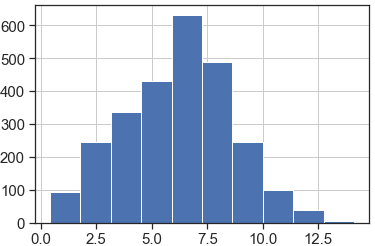

In [38]:
expression_loc[~expression_loc.annotation_quality.isin(['low', 'low-expr'])].mean_log_tpm.hist()

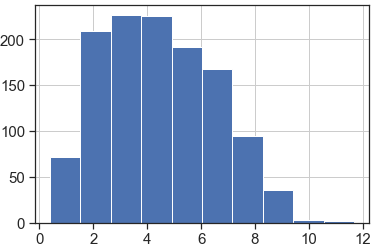

In [39]:
expression_loc[expression_loc.annotation_quality.isin(['low', 'low-expr'])].mean_log_tpm.hist()

In [40]:
expression_loc.annotation_quality.value_counts()

high        2559
low         1140
low-expr      84
excluded      49
Name: annotation_quality, dtype: int64

[]

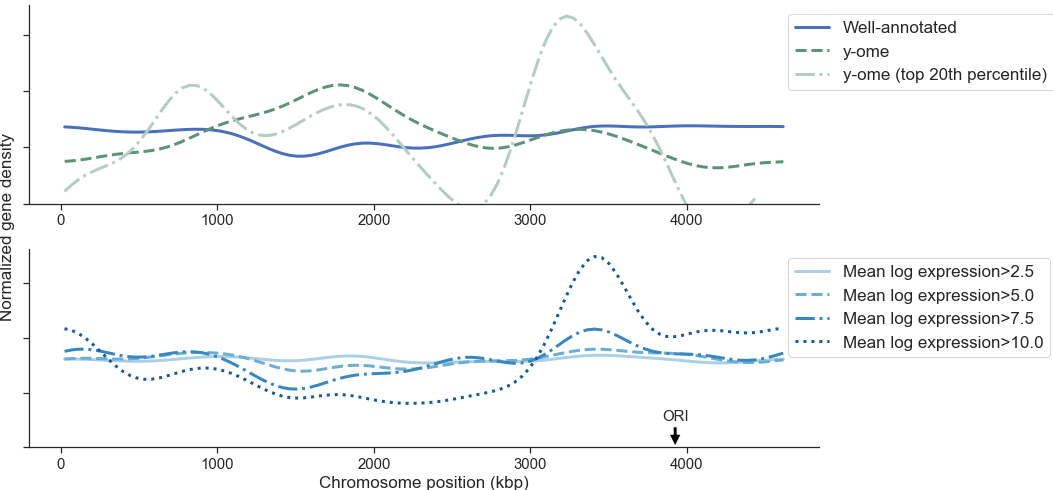

In [45]:
fig, axes = plt.subplots(nrows=2, figsize=(12,7))
fig.tight_layout()

ax = axes.flatten()[0]
for ann, label, color, dash in [('high', 'Well-annotated', 'blue', '-'), 
                                ('low', 'y-ome', 'green', '--'),
                                ('low-expr', f'y-ome (top 20th percentile)', 'green grey', '-.')
                               ]:
    data = expression_loc[expression_loc.annotation_quality.str.contains(ann)].loc[:, 'start']
    max_val = max(data)
    normalized = (data * 2 * np.pi / max_val) - np.pi
    bins, kde = vonmises_fft_kde(data=normalized.values, kappa=10, n_bins=100)
    final_bins = (bins + np.pi) * max_val / (2 * np.pi) / 1000
    ax.plot(final_bins, kde, dash, label=label, color=colors[color])
ax.legend(bbox_to_anchor=(0.95,1), loc="upper left")
# hide top and right axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticklabels([])
ax.set_ylim(bottom=0.1)
# ax.set_ylabel('Gene density')
# ax.set_xlabel('Chromosome position (kbp)')
# fig.savefig('/Users/zaking/lab/y-ome/gene-location.pdf')
# fig.savefig('/Users/zaking/lab/y-ome/gene-location.png')


ax = axes.flatten()[1]
to_hist_later = {}
for cutoff, color, dots in zip(np.linspace(2.5, 10, 4), 
                               sns.color_palette("Blues", n_colors=5)[1:],
                               ['-', '--', '-.', ':']):
    data = expression_loc[expression_loc.mean_log_tpm > cutoff].start
    to_hist_later[cutoff] = data
    max_val = max(data)
    normalized = (data * 2 * np.pi / max_val) - np.pi
    bins, kde = vonmises_fft_kde(data=normalized.values, kappa=10, n_bins=100)
    final_bins = (bins + np.pi) * max_val / (2 * np.pi) / 1000
    ax.plot(final_bins, kde, dots, label=f'Mean log expression>{cutoff:.1f}', color=color)
ax.legend(bbox_to_anchor=(0.95,1), loc="upper left")
# hide top and right axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticklabels([])
ax.set_ylim(bottom=0)
# ax.set_ylabel('Gene density')
ax.set_xlabel('Chromosome position (kbp)')

# ORI and TER
ax.annotate('ORI', xy=(3925744/1000, 0), xytext=(3925744/1000, 0.05),
            horizontalalignment='center', 
            arrowprops=dict(facecolor='black', shrink=0.05))

# Create a shared y-axis label
ax = fig.add_subplot(111, frameon=False)
ax.set_ylabel('Normalized gene density')
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks_position('none')
ax.yaxis.set_ticklabels([])
ax.xaxis.set_ticks_position('none')
ax.xaxis.set_ticklabels([])

# fig.savefig('/Users/zaking/lab/y-ome/figs/gene-location-expression.pdf')
# fig.savefig('/Users/zaking/lab/y-ome/figs/gene-location-expression.png')